## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f01020.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06390.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f01830.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f02340_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01230_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009150_P.png')]

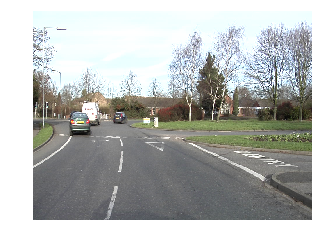

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

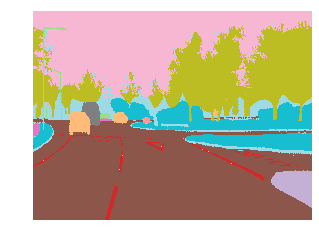

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [14]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

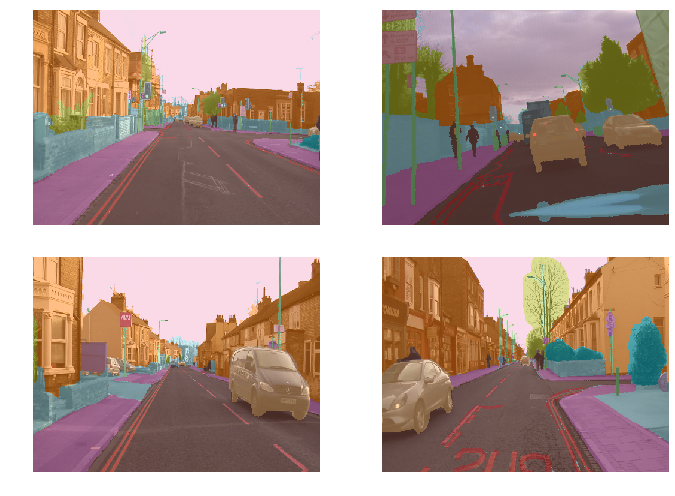

In [16]:
data.show_batch(2, figsize=(10,7))

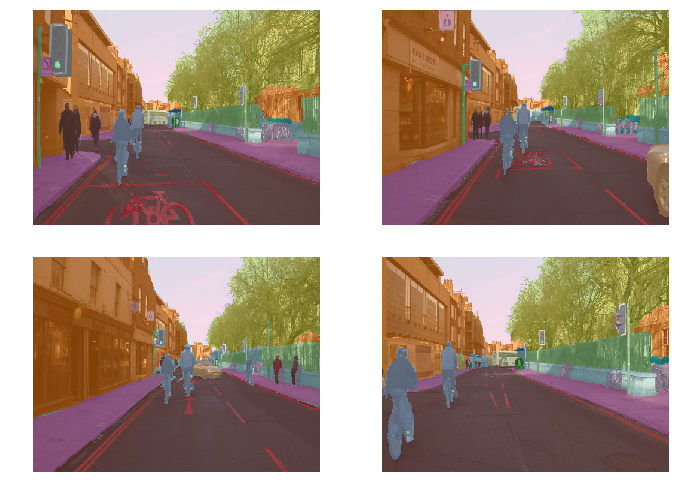

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [21]:
free = gpu_mem_get_free_no_cache()
free

7180

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
metrics=acc_camvid
# metrics=accuracy

In [24]:
wd=1e-2

In [25]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


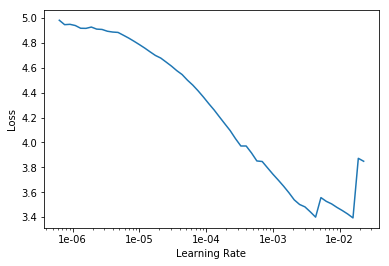

In [26]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lr=3e-3

In [28]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.996349,0.784354,0.829778,01:46
1,0.748093,0.730865,0.774897,01:47
2,0.680890,0.535681,0.854703,01:47
3,0.636308,0.577038,0.844305,01:46
4,0.584782,0.455038,0.876433,01:45
5,0.586219,0.452001,0.869591,01:44
6,0.580063,0.494607,0.874683,01:44
7,0.546991,0.430174,0.884136,01:43
8,0.504373,0.439205,0.878266,01:43
9,0.411274,0.328160,0.900441,01:43


In [29]:
learn.save('stage-1')

In [30]:
learn.load('stage-1');

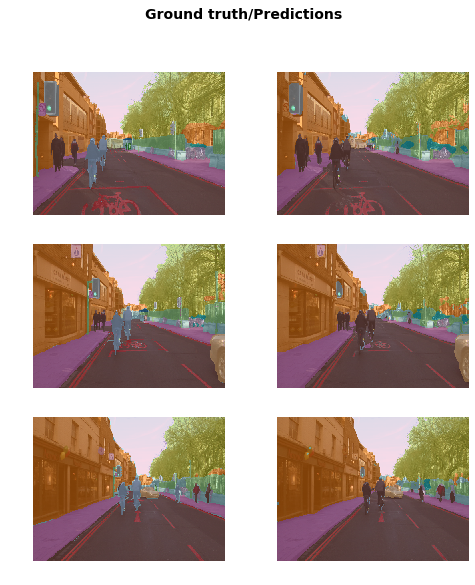

In [31]:
learn.show_results(rows=3, figsize=(8,9))

In [32]:
learn.unfreeze()

In [33]:
lrs = slice(lr/400,lr/4)

In [34]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.377155,0.318999,0.903215,01:49
1,0.364415,0.307216,0.909624,01:49
2,0.361500,0.315083,0.908235,01:49
3,0.342466,0.302352,0.912703,01:49
4,0.341586,0.298429,0.913948,01:49
5,0.342511,0.298006,0.914884,01:50
6,0.337344,0.290604,0.920440,01:49
7,0.314652,0.298192,0.915928,01:49
8,0.329811,0.291258,0.916097,01:50
9,0.311487,0.275261,0.922348,01:50


In [35]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [36]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 6214MB of GPU RAM free


In [37]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [38]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [39]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


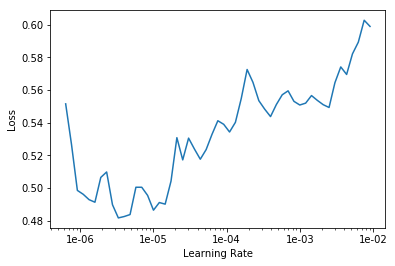

In [40]:
lr_find(learn)
learn.recorder.plot()

In [41]:
lr=1e-3

In [42]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.432812,0.310374,0.913432,10:02
1,0.383260,0.290855,0.920935,07:11
2,0.325401,0.351451,0.911948,07:11
3,0.342926,0.341838,0.912877,07:11
4,0.355347,0.277238,0.925383,07:10
5,0.395044,0.279655,0.927434,07:10
6,0.366737,0.321461,0.911190,07:10
7,0.332265,0.279058,0.925554,07:10
8,0.283569,0.353396,0.914950,07:10
9,0.232629,0.257393,0.933498,07:10


In [43]:
learn.save('stage-1-big')

In [44]:
learn.load('stage-1-big');

In [45]:
learn.unfreeze()

In [46]:
lrs = slice(1e-6,lr/10)

In [47]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time


RuntimeError: CUDA out of memory. Tried to allocate 261.12 MiB (GPU 0; 7.43 GiB total capacity; 4.09 GiB already allocated; 226.94 MiB free; 784.02 MiB cached)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin